## This notebook is for Part c of the project.

Name: Xi Chen
<br>
Github Username: Alicella
<br>
USC ID: 8869487524

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
# import cv2
import matplotlib.pyplot as plt

In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

## Loading and pre processing the data
<!-- Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results. -->

In [4]:
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from PIL import Image 


def augment_image(image):
    # Define a list of augmentation operations
    # augmentation_operations = [
    #     layers.RandomFlip("horizontal_and_vertical"),
    #     layers.RandomRotation(0.2),
    #     layers.RandomContrast(factor=0.5),
    #     layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    #     layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    #     # layers.RandomCrop(200, 200)
    # ]

    # # Shuffle the list of augmentation operations
    # random.shuffle(augmentation_operations)

    # # Apply three randomly selected augmentation operations
    # for operation in augmentation_operations[:3]:
    #     image = operation(image)

    image = layers.RandomFlip("horizontal_and_vertical")(image)
    image = layers.RandomRotation(0.2)(image)
    image = layers.RandomContrast(factor=0.5)(image)
    image = layers.RandomTranslation(height_factor=0.2, width_factor=0.2)(image)
    image = layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))(image)

    return image

def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])

        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Augment the image
        # Randomly decide whether to augment the image
        # should_augment = tf.random.uniform(shape=[], minval=0, maxval=1) < 0.2  # 20% chance of augmentation

        # Apply data augmentation if decided to augment
        # if should_augment:
        # img = augment_image(img)
            # img = tf.image.resize(img, [299, 299])   # Resize the image back to the original size after augmentation

        label = 1 if label_str=='frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])  # Scalar label

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)


tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

## （c) Training CNN + MLP

In [5]:
# for (img, label) in tf_dataset_train:
#     print(img.numpy().shape)
#     print(label.numpy().shape)
#     break
# for sample in tf_dataset_train.take(5):
#     print(sample)

### (i) Image augmentation

In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

original_height, original_width, channels = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
cropped_height, cropped_width = (200, 00)
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(factor=0.5),  # Adjust contrast
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  # Translate horizontally and vertically
  # layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),  # Zoom into or out of the image
  # layers.RandomCrop(height=cropped_height, width=cropped_width)  # Randomly crop the image
])

### (ii) Train a CNN model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard    # tensorboard --logdir logs
from tensorflow.keras.optimizers.legacy import Adam
# from tensorflow.keras.metrics import Precision, Recall, F1Score
import time

In [8]:
INPUT_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
NUM_CLASSES = 2  # frost or background

# NAME = f'frost_vs_bg_cnn_32x3_{int(time.time())}'
# tensorboard = TensorBoard(log_dir=f'./logs/{NAME}')

model = Sequential()

input_layer = Input(shape=INPUT_SHAPE)
model.add(input_layer)

# Randomly decide whether to augment the image
should_augment = tf.random.uniform(shape=[], minval=0, maxval=1) < 0.4  # 40% chance of augmentation
if should_augment:
    model.add(data_augmentation)

# Convolutional layers 1
model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layers 2
model.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layers 3
model.add(Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))   # not sure if this is needed

 # Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# Dense layer with dropout and L2 regularization
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(NUM_CLASSES, activation='softmax'))

customize_optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=customize_optimizer, 
              # optimizer='adam',
              loss='sparse_categorical_crossentropy',    # binary_crossentropy? categorical_crossentropy?
              metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)   #start_from_epoch=20, 

# Train the model using the tf_dataset_train and validate on tf_dataset_val
history = model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping])  #, tensorboard

# Display the model summary
model.summary()

Epoch 1/20
928/928 [==============================] - 704s 757ms/step - loss: 25.4837 - accuracy: 0.7888 - val_loss: 16.5907 - val_accuracy: 0.8503
Epoch 2/20
928/928 [==============================] - 732s 788ms/step - loss: 13.1034 - accuracy: 0.8697 - val_loss: 10.6482 - val_accuracy: 0.9000
Epoch 3/20
928/928 [==============================] - 671s 722ms/step - loss: 9.3711 - accuracy: 0.9045 - val_loss: 8.4085 - val_accuracy: 0.8744
Epoch 4/20
928/928 [==============================] - 677s 729ms/step - loss: 7.7306 - accuracy: 0.9226 - val_loss: 7.3908 - val_accuracy: 0.7929
Epoch 5/20
928/928 [==============================] - 664s 715ms/step - loss: 6.8198 - accuracy: 0.9322 - val_loss: 6.6037 - val_accuracy: 0.8529
Epoch 6/20
928/928 [==============================] - 663s 714ms/step - loss: 6.2274 - accuracy: 0.9382 - val_loss: 6.0611 - val_accuracy: 0.8972
Epoch 7/20
928/928 [==============================] - 668s 719ms/step - loss: 5.7848 - accuracy: 0.9465 - val_loss: 5.62

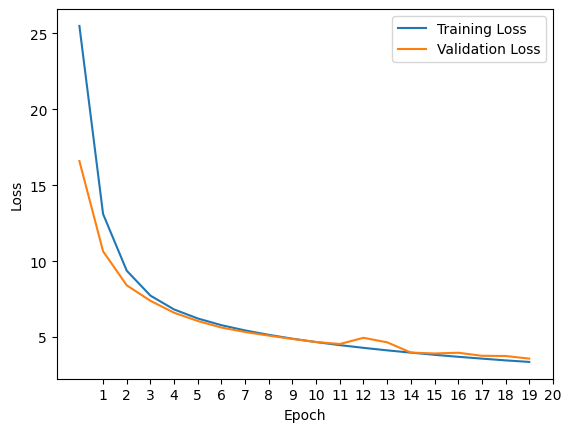

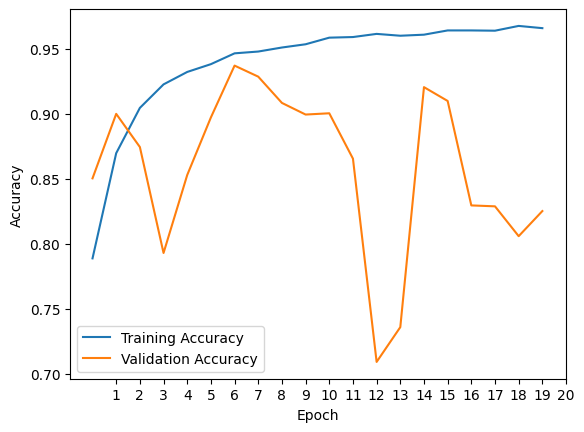

In [19]:
# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, len(history.history['accuracy']) + 1)) 
plt.legend()
plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(history.history['accuracy']) + 1)) 
plt.legend()
plt.show()

### (iii) Evaluate the model

In [18]:
# refer to Piazza post https://piazza.com/class/lll6cacyxjfg3/post/1107_f4 and 
# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from sklearn.metrics import classification_report

true_labels = []
predicted_labels = []
for images, labels in tf_dataset_test.unbatch():
    true_labels.append(labels.numpy())

true_labels = np.array(true_labels).flatten()

predicted_probs = model.predict(tf_dataset_test)
for prob in predicted_probs:
    if prob[0] > prob[1]:
        predicted_labels.append(0)
    else:
        predicted_labels.append(1)

report = classification_report(true_labels, predicted_labels)
print(report)

401/401 [==============================] - 97s 232ms/step
              precision    recall  f1-score   support

           0       0.35      0.37      0.36      4418
           1       0.66      0.64      0.65      8405

    accuracy                           0.55     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.55      0.55     12823



In [13]:
evaluation_result = model.evaluate(tf_dataset_test)
test_loss, test_accuracy = evaluation_result
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

401/401 [==============================] - 89s 220ms/step - loss: 3.3417 - accuracy: 0.9485
Test loss: 3.341700792312622
Test accuracy: 0.9484519958496094


## Reference

How to extract data/labels back from TensorFlow dataset https://stackoverflow.com/questions/56226621/how-to-extract-data-labels-back-from-tensorflow-dataset  

Python kernel dies on Jupyter Notebook with tensorflow 2 https://stackoverflow.com/questions/59576397/python-kernel-dies-on-jupyter-notebook-with-tensorflow-2  

where to put batch-norm: https://www.baeldung.com/cs/batch-normalization-cnn  
https://stackoverflow.com/questions/47143521/where-to-apply-batch-normalization-on-standard-cnns

image augmentation: https://www.tensorflow.org/tutorials/images/data_augmentation#option_1_make_the_preprocessing_layers_part_of_your_model  

metal plugin https://developer.apple.com/forums/thread/725376